In [1]:
# for reading and validating data
import emeval.input.spec_details as eisd
import emeval.input.phone_view as eipv
import emeval.input.eval_view as eiev

In [2]:
# Visualization helpers
import emeval.viz.phone_view as ezpv
import emeval.viz.eval_view as ezev

In [3]:
# for pipelined data
import emeval.analysed.phone_view as eapv

In [4]:
import pandas as pd

In [5]:
import geopandas as gpd
import shapely as shp
import shapely.geometry as shpgeo

In [6]:
import emeval.viz.geojson as ezgj

In [7]:
import numpy as np

In [8]:
import emeval.metrics.dist_calculations as emd

/home/gabrielkosmacher/miniconda-4.7.12/envs/emissioneval/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/gabrielkosmacher/miniconda-4.7.12/envs/emissioneval/lib/python3.8/site-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/home/gabrielkosmacher/miniconda-4.7.12/envs/emissioneval/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<au

In [9]:
# For plots
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# Analytics results
import emeval.metrics.segmentation as ems

In [11]:
# for statistics
import scipy as sp
import scipy.stats as spst 

In [12]:
# For easier debugging while working on modules
import importlib

In [13]:
import sys 

In [14]:
sys.path.append('/home/gabrielkosmacher/Documents/nrel/e-mission-server')

In [15]:
import emission.analysis.intake.cleaning.location_smoothing as eaicl

In [16]:
# json
import json

In [17]:
DATASTORE_LOC = "bin/data"
AUTHOR_EMAIL = "shankari@eecs.berkeley.edu"
sd_la = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "unimodal_trip_car_bike_mtv_la")
sd_sj = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "car_scooter_brex_san_jose")
sd_ucb = eisd.FileSpecDetails(DATASTORE_LOC, AUTHOR_EMAIL, "train_bus_ebike_mtv_ucb")

After iterating over 1 entries, entry found
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
After iterating over 1 entries, entry found
Found spec = Multi-modal car scooter BREX trip to San Jose
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
After iterating over 1 entries, entry found
Found spec = Multimodal multi-train, multi-bus, ebike trip to UC Berkeley
Evaluation ran from 2019-07-16T00:00:00-07:00 -> 2020-04-30T00:00:00-07:00


In [18]:
pv_la = eipv.PhoneView(sd_la)
pv_sj = eipv.PhoneView(sd_sj)
pv_ucb = eipv.PhoneView(sd_ucb)

-------------------- About to read transitions from server --------------------
Reading data for android phones
Loading transitions for phone ucb-sdb-android-1
Loading transitions for phone ucb-sdb-android-2
Loading transitions for phone ucb-sdb-android-3
Loading transitions for phone ucb-sdb-android-4
Reading data for ios phones
Loading transitions for phone ucb-sdb-ios-1
Loading transitions for phone ucb-sdb-ios-2
Loading transitions for phone ucb-sdb-ios-3
Loading transitions for phone ucb-sdb-ios-4
-------------------- About to fill calibration ranges --------------------
Processing data for android phones
Processing transitions for phone ucb-sdb-android-1
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-2
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-3
Filtered 86 total -> 0 calibration transitions 
Processing transitions for phone ucb-sdb-android-4
Filtered 86 total -> 0 calibration

Processing data for ios phones
-------------------- About to fill in motion activity information --------------------
Processing data for android phones
Processing data for ios phones
Processing data for android phones
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not b

Processing data for ios phones
-------------------- About to fill in location information --------------------
Processing data for android phones
Processing data for ios phones
Processing data for android phones
Processing data for ios phones
-------------------- About to fill in motion activity information --------------------
Processing data for android phones
Processing data for ios phones
Processing data for android phones
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
mo

-------------------- About to fill in location information --------------------
Processing data for android phones
Processing data for ios phones
Processing data for android phones
Processing data for ios phones
-------------------- About to fill in motion activity information --------------------
Processing data for android phones
Processing data for ios phones
Processing data for android phones
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been processed, copying write_ts -> ts
motion activity has not been proc

Filling label ucb-sdb-android-2 for OS android
Filling label ucb-sdb-android-3 for OS android
Filling label ucb-sdb-android-4 for OS android
Filling label ucb-sdb-ios-1 for OS ios
Filling label ucb-sdb-ios-2 for OS ios
Filling label ucb-sdb-ios-3 for OS ios
Filling label ucb-sdb-ios-4 for OS ios
-------------------- Done populating information from server --------------------


In [38]:
%%capture
ems.fill_sensed_section_ranges(pv_la)
ems.fill_sensed_section_ranges(pv_sj)
ems.fill_sensed_section_ranges(pv_ucb)

In [19]:
import copy

In [20]:
MASTER_DATA_LOC = "bin/data/master_9b70c97"
master_spec = eisd.FileSpecDetails(MASTER_DATA_LOC, AUTHOR_EMAIL)

In [21]:
av_la = copy.deepcopy(eapv.create_analysed_view(pv_la, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
av_sj = copy.deepcopy(eapv.create_analysed_view(pv_sj, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))
av_ucb = copy.deepcopy(eapv.create_analysed_view(pv_ucb, master_spec, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section"))

Finished copying unimodal_trip_car_bike_mtv_la, starting overwrite
Found spec = Round trip car and bike trip in the South Bay
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:ACCURACY

Before filtering, trips = []
Filter range = 2019-08-31T10:07:27.557744-07:00 -> 2019-08-31T10:23:08.473621-07:00
After filtering, trips = []
Before filtering, trips = []
Filter range = 2019-08-31T11:30:50.166396-07:00 -> 2019-08-31T11:52:38.771930-07:00
After filtering, trips = []
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:POWER_CONTROL_5 HAHFDC v/s MAHFDC power_control_2 2
Before filtering, trips = []
Filter range = 2019-08-31T14:57:42.798072-07:00 -> 2019-08-31T15:14:48.798746-07:00
After filtering, trips = []
Before filtering, trips = []
Filter range = 2019-08-31T16:30:05.301877-07:00 -> 2019-08-31T16

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         HAHFDC v/s HAMFDC:HAHFDC_1 HAHFDC v/s HAMFDC HAHFDC_1 2
Before filtering, trips = [('2019-08-31T10:25:07.058955-07:00', '2019-08-31T11:48:40.995877-07:00'), ('2019-08-31T11:48:41.995913-07:00', '2019-08-31T11:52:13.989582-07:00'), ('2019-08-31T11:52:15.989512-07:00', '2019-08-31T11:54:17.429140-07:00')]
Filter range = 2019-08-31T10:07:27.557744-07:00 -> 2019-08-31T10:23:08.473621-07:00
After filtering, trips = []
Before filtering, trips = [('2019-08-31T10:25:07.058955-07:00', '2019-08-31T11:48:40.995877-07:00'), ('2019-08-31T11:48:41.995913-07:00', '2019-08-31T11:52:1

Finished copying car_scooter_brex_san_jose, starting overwrite
Found spec = Multi-modal car scooter BREX trip to San Jose
Evaluation ran from 2019-07-20T00:00:00-07:00 -> 2020-04-29T17:00:00-07:00
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed:ACCURACY_CON

Before filtering, trips = [('2019-07-23T08:51:18.945000-07:00', '2019-07-23T09:18:57.215000-07:00'), ('2019-07-23T09:19:29-07:00', '2019-07-23T09:21:33.601000-07:00'), ('2019-07-23T12:42:42.736306-07:00', '2019-07-23T12:46:24-07:00'), ('2019-07-23T12:46:54-07:00', '2019-07-23T13:05:46-07:00'), ('2019-07-23T13:08:20.846226-07:00', '2019-07-23T13:51:11.665000-07:00'), ('2019-07-23T13:51:24-07:00', '2019-07-23T14:01:54.639000-07:00')]
Filter range = 2019-07-23T08:46:49.339100-07:00 -> 2019-07-23T09:19:38.321992-07:00
After filtering, trips = ['2019-07-23T08:51:18.945000-07:00', '2019-07-23T09:19:29-07:00']
Before filtering, trips = [('2019-07-23T08:51:18.945000-07:00', '2019-07-23T09:18:57.215000-07:00'), ('2019-07-23T09:19:29-07:00', '2019-07-23T09:21:33.601000-07:00'), ('2019-07-23T12:42:42.736306-07:00', '2019-07-23T12:46:24-07:00'), ('2019-07-23T12:46:54-07:00', '2019-07-23T13:05:46-07:00'), ('2019-07-23T13:08:20.846226-07:00', '2019-07-23T13:51:11.665000-07:00'), ('2019-07-23T13:51:2

         HAHFDC v/s MAHFDC:HAHFDC_2 HAHFDC v/s MAHFDC HAHFDC_2 2
Before filtering, trips = [('2019-07-27T09:19:10.999951-07:00', '2019-07-27T09:40:03.997236-07:00'), ('2019-07-27T09:40:04.997202-07:00', '2019-07-27T09:40:16.996794-07:00'), ('2019-07-27T09:40:20.996656-07:00', '2019-07-27T09:44:24.514260-07:00'), ('2019-07-27T12:56:41.702540-07:00', '2019-07-27T12:58:58.997901-07:00'), ('2019-07-27T12:58:59.997857-07:00', '2019-07-27T12:59:53.995479-07:00'), ('2019-07-27T12:59:54.995434-07:00', '2019-07-27T12:59:58.995258-07:00'), ('2019-07-27T12:59:59.995213-07:00', '2019-07-27T13:07:10.996253-07:00'), ('2019-07-27T13:07:11.996214-07:00', '2019-07-27T13:07:20.995871-07:00'), ('2019-07-27T13:07:21.995832-07:00', '2019-07-27T13:16:57.993784-07:00'), ('2019-07-27T13:16:59.993730-07:00', '2019-07-27T13:24:14.990963-07:00'), ('2019-07-27T13:24:15.990926-07:00', '2019-07-27T13:25:08.989007-07:00'), ('2019-07-27T13:25:09.988971-07:00', '2019-07-27T13:25:28.988283-07:00'), ('2019-07-27T13:25:2

Before filtering, trips = [('2019-08-05T10:32:22.335140-07:00', '2019-08-05T10:55:34.997035-07:00'), ('2019-08-05T10:56:02.996000-07:00', '2019-08-05T10:57:49.991994-07:00'), ('2019-08-05T15:04:31.337241-07:00', '2019-08-05T15:09:56.988751-07:00'), ('2019-08-05T15:10:21.987585-07:00', '2019-08-05T15:10:21.987585-07:00'), ('2019-08-05T15:10:52.986137-07:00', '2019-08-05T15:10:52.986137-07:00'), ('2019-08-05T15:11:00.985764-07:00', '2019-08-05T15:13:08.979793-07:00'), ('2019-08-05T15:13:59.977416-07:00', '2019-08-05T15:13:59.977416-07:00'), ('2019-08-05T15:14:07.989907-07:00', '2019-08-05T15:22:42.979539-07:00'), ('2019-08-05T15:22:50.979212-07:00', '2019-08-05T15:22:50.979212-07:00'), ('2019-08-05T15:22:56.978963-07:00', '2019-08-05T15:26:47.992232-07:00'), ('2019-08-05T15:34:35.991219-07:00', '2019-08-05T15:34:42.990969-07:00'), ('2019-08-05T15:34:45.990864-07:00', '2019-08-05T16:08:43.994686-07:00'), ('2019-08-05T16:09:33.992770-07:00', '2019-08-05T16:18:29.994664-07:00')]
Filter rang

Finished copying train_bus_ebike_mtv_ucb, starting overwrite
Found spec = Multimodal multi-train, multi-bus, ebike trip to UC Berkeley
Evaluation ran from 2019-07-16T00:00:00-07:00 -> 2020-04-30T00:00:00-07:00
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
android dict_keys(['ucb-sdb-android-1', 'ucb-sdb-android-2', 'ucb-sdb-android-3', 'ucb-sdb-android-4'])
     -*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
     ucb-sdb-android-1 accuracy_control dict_keys(['role', 'manual/evaluation_transition', 'calibration_transitions', 'calibration_ranges', 'evaluation_transitions', 'evaluation_ranges'])
         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         fixed

Before filtering, trips = [('2019-09-10T08:11:45.580000-07:00', '2019-09-10T08:28:06-07:00'), ('2019-09-10T08:30:57.622500-07:00', '2019-09-10T09:07:24-07:00'), ('2019-09-10T09:07:26-07:00', '2019-09-10T09:08:04-07:00'), ('2019-09-10T09:19:09.871847-07:00', '2019-09-10T10:14:03.425000-07:00'), ('2019-09-10T10:14:13.451000-07:00', '2019-09-10T10:19:45-07:00'), ('2019-09-10T10:28:08.205705-07:00', '2019-09-10T10:36:42-07:00'), ('2019-09-10T13:39:33.901504-07:00', '2019-09-10T13:52:51-07:00'), ('2019-09-10T16:11:43.889654-07:00', '2019-09-10T16:17:46-07:00'), ('2019-09-10T16:17:47-07:00', '2019-09-10T16:30:23-07:00'), ('2019-09-10T16:30:25-07:00', '2019-09-10T16:31:33-07:00'), ('2019-09-10T16:31:35-07:00', '2019-09-10T16:41:32-07:00'), ('2019-09-10T16:52:22.829326-07:00', '2019-09-10T17:32:52-07:00'), ('2019-09-10T17:32:53-07:00', '2019-09-10T17:33:26-07:00'), ('2019-09-10T17:48:06.319446-07:00', '2019-09-10T18:01:52-07:00'), ('2019-09-10T18:01:55-07:00', '2019-09-10T18:04:20-07:00'), ('2

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         MAMFDC v/s HAMFDC:MAMFDC_2 MAMFDC v/s HAMFDC MAMFDC_2 3
Before filtering, trips = [('2019-12-03T08:16:57.027000-08:00', '2019-12-03T08:30:25.528000-08:00'), ('2019-12-03T08:41:38.478000-08:00', '2019-12-03T09:13:39.520000-08:00'), ('2019-12-03T09:17:52.781573-08:00', '2019-12-03T10:19:07.899000-08:00'), ('2019-12-03T10:27:42.457942-08:00', '2019-12-03T10:34:05.923000-08:00'), ('2019-12-03T14:14:57.823089-08:00', '2019-12-03T14:28:10.982000-08:00'), ('2019-12-03T16:16:05.528018-08:00', '2019-12-03T16:21:06.134000-08:00'), ('2019-12-03T16:22:10.099000-08:00', '2019-12-0

Before filtering, trips = [('2020-02-06T08:17:54.066000-08:00', '2020-02-06T08:27:01.474000-08:00'), ('2020-02-06T08:33:17.674182-08:00', '2020-02-06T09:10:45.548000-08:00'), ('2020-02-06T09:12:22.496000-08:00', '2020-02-06T09:14:30.481000-08:00'), ('2020-02-06T09:17:30.481000-08:00', '2020-02-06T10:17:06.028000-08:00'), ('2020-02-06T10:22:57.080719-08:00', '2020-02-06T10:29:21.951000-08:00'), ('2020-02-06T10:29:52.939000-08:00', '2020-02-06T10:30:57.059000-08:00'), ('2020-02-06T13:08:18.314395-08:00', '2020-02-06T13:21:52.184000-08:00'), ('2020-02-06T16:17:24.294441-08:00', '2020-02-06T16:24:16.147000-08:00'), ('2020-02-06T16:24:48.186000-08:00', '2020-02-06T16:37:11.210000-08:00'), ('2020-02-06T16:37:43.092000-08:00', '2020-02-06T16:37:43.092000-08:00'), ('2020-02-06T16:38:16.128000-08:00', '2020-02-06T16:47:23.156000-08:00'), ('2020-02-06T16:51:03.883336-08:00', '2020-02-06T17:28:53.992000-08:00'), ('2020-02-06T17:29:59.035000-08:00', '2020-02-06T17:37:58.996000-08:00'), ('2020-02-0

Before filtering, trips = [('2019-09-10T08:16:30.741000-07:00', '2019-09-10T08:28:20.210000-07:00'), ('2019-09-10T08:31:12.185000-07:00', '2019-09-10T09:07:38.118000-07:00'), ('2019-09-10T09:07:43.212000-07:00', '2019-09-10T09:11:42.707000-07:00'), ('2019-09-10T09:17:06.068000-07:00', '2019-09-10T10:13:36.272000-07:00'), ('2019-09-10T10:14:17.344000-07:00', '2019-09-10T10:16:02.221000-07:00'), ('2019-09-10T10:26:11.325255-07:00', '2019-09-10T10:35:31-07:00'), ('2019-09-10T10:35:47.152000-07:00', '2019-09-10T10:37:43.239000-07:00'), ('2019-09-10T13:38:52.057667-07:00', '2019-09-10T13:52:21.432000-07:00'), ('2019-09-10T16:12:15.599000-07:00', '2019-09-10T16:17:55.660000-07:00'), ('2019-09-10T16:18:11.583000-07:00', '2019-09-10T16:28:36.221000-07:00'), ('2019-09-10T16:28:51.019000-07:00', '2019-09-10T16:29:43.502000-07:00'), ('2019-09-10T16:29:53.535000-07:00', '2019-09-10T16:30:42.270000-07:00'), ('2019-09-10T16:30:47.358000-07:00', '2019-09-10T16:31:55.671000-07:00'), ('2019-09-10T16:32

Before filtering, trips = [('2019-11-20T08:13:52.381000-08:00', '2019-11-20T08:29:31-08:00'), ('2019-11-20T08:30:32-08:00', '2019-11-20T09:08:44.076000-08:00'), ('2019-11-20T09:09:09-08:00', '2019-11-20T09:10:07-08:00'), ('2019-11-20T09:18:03.920187-08:00', '2019-11-20T10:09:48-08:00'), ('2019-11-20T10:14:28.047000-08:00', '2019-11-20T10:16:31.704000-08:00'), ('2019-11-20T10:25:50.776695-08:00', '2019-11-20T10:30:13-08:00'), ('2019-11-20T10:30:42-08:00', '2019-11-20T10:31:53-08:00'), ('2019-11-20T13:48:22.696511-08:00', '2019-11-20T14:00:18-08:00'), ('2019-11-20T16:17:31.189564-08:00', '2019-11-20T16:24:40-08:00'), ('2019-11-20T16:24:45-08:00', '2019-11-20T16:43:41.689000-08:00'), ('2019-11-20T17:18:48.078000-08:00', '2019-11-20T17:48:01-08:00'), ('2019-11-20T17:48:30.803000-08:00', '2019-11-20T17:59:02.509000-08:00'), ('2019-11-20T18:00:24-08:00', '2019-11-20T18:12:23.046000-08:00'), ('2019-11-20T18:12:28-08:00', '2019-11-20T18:16:59-08:00'), ('2019-11-20T18:17:28-08:00', '2019-11-20T

Before filtering, trips = [('2020-02-06T08:16:27.886000-08:00', '2020-02-06T08:29:48.443000-08:00'), ('2020-02-06T08:30:03.600000-08:00', '2020-02-06T08:31:09.327000-08:00'), ('2020-02-06T08:32:19-08:00', '2020-02-06T08:33:28.510000-08:00'), ('2020-02-06T08:34:55.903000-08:00', '2020-02-06T09:10:32.847000-08:00'), ('2020-02-06T09:10:42.976000-08:00', '2020-02-06T09:11:53.823000-08:00'), ('2020-02-06T09:12:33.814994-08:00', '2020-02-06T10:10:56.852000-08:00'), ('2020-02-06T10:14:29.192000-08:00', '2020-02-06T10:16:39.807000-08:00'), ('2020-02-06T13:06:11.492273-08:00', '2020-02-06T13:21:49.811000-08:00'), ('2020-02-06T16:16:40.145979-08:00', '2020-02-06T16:23:57.824000-08:00'), ('2020-02-06T16:24:18.084000-08:00', '2020-02-06T16:33:39.115000-08:00'), ('2020-02-06T16:33:44.189000-08:00', '2020-02-06T16:34:09.506000-08:00'), ('2020-02-06T16:34:14.586000-08:00', '2020-02-06T16:35:52.757000-08:00'), ('2020-02-06T16:36:02.863000-08:00', '2020-02-06T16:36:12.965000-08:00'), ('2020-02-06T16:36

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         HAHFDC v/s HAMFDC:HAHFDC_0 HAHFDC v/s HAMFDC HAHFDC_0 3
Before filtering, trips = [('2019-09-10T08:16:48.704241-07:00', '2019-09-10T08:31:04.989569-07:00'), ('2019-09-10T08:31:05.989530-07:00', '2019-09-10T09:06:48.988289-07:00'), ('2019-09-10T09:07:23.998441-07:00', '2019-09-10T09:19:51.644861-07:00'), ('2019-09-10T09:32:55.783426-07:00', '2019-09-10T10:10:25.512905-07:00'), ('2019-09-10T10:14:26.201447-07:00', '2019-09-10T10:33:58.998805-07:00'), ('2019-09-10T10:33:59.998803-07:00', '2019-09-10T10:35:33.996101-07:00'), ('2019-09-10T10:35:34.996066-07:00', '2019-09-1

         dict_keys(['trip_id', 'trip_id_base', 'trip_run', 'start_ts', 'end_ts', 'duration', 'eval_common_trip_id', 'eval_role', 'eval_role_base', 'eval_role_run', 'evaluation_trip_ranges', 'background/battery', 'battery_df', 'background/location', 'background/filtered_location', 'location_df', 'filtered_location_df', 'background/motion_activity', 'motion_activity_df', 'statemachine/transition', 'transition_df'])
         MAMFDC v/s MAHFDC:MAMFDC_1 MAMFDC v/s MAHFDC MAMFDC_1 3
Before filtering, trips = [('2019-11-20T08:24:51.894915-08:00', '2019-11-20T09:04:16.465450-08:00'), ('2019-11-20T09:04:30.497197-08:00', '2019-11-20T09:06:09.850701-08:00'), ('2019-11-20T09:06:16.271218-08:00', '2019-11-20T09:07:22.279812-08:00'), ('2019-11-20T09:07:43.894733-08:00', '2019-11-20T09:19:22.344031-08:00'), ('2019-11-20T09:21:08.556138-08:00', '2019-11-20T10:10:43.312654-08:00'), ('2019-11-20T10:14:44.860515-08:00', '2019-11-20T10:28:22.016576-08:00'), ('2019-11-20T10:28:28.550196-08:00', '2019-11-2

Before filtering, trips = [('2020-02-06T08:23:15.894629-08:00', '2020-02-06T08:25:02.736740-08:00'), ('2020-02-06T08:26:00.821645-08:00', '2020-02-06T08:34:58.642714-08:00'), ('2020-02-06T08:35:36.623463-08:00', '2020-02-06T08:57:36.177141-08:00'), ('2020-02-06T18:42:26.341399-08:00', '2020-02-06T18:56:51.030249-08:00'), ('2020-02-06T18:57:10.358475-08:00', '2020-02-06T19:19:47.315187-08:00')]
Filter range = 2020-02-06T08:14:46.468857-08:00 -> 2020-02-06T10:30:08.723332-08:00
After filtering, trips = ['2020-02-06T08:23:15.894629-08:00', '2020-02-06T08:26:00.821645-08:00', '2020-02-06T08:35:36.623463-08:00']
Before filtering, trips = [('2020-02-06T08:23:15.894629-08:00', '2020-02-06T08:25:02.736740-08:00'), ('2020-02-06T08:26:00.821645-08:00', '2020-02-06T08:34:58.642714-08:00'), ('2020-02-06T08:35:36.623463-08:00', '2020-02-06T08:57:36.177141-08:00'), ('2020-02-06T18:42:26.341399-08:00', '2020-02-06T18:56:51.030249-08:00'), ('2020-02-06T18:57:10.358475-08:00', '2020-02-06T19:19:47.3151

Before filtering, trips = [('2019-09-10T08:21:37.696816-07:00', '2019-09-10T08:22:28.998484-07:00'), ('2019-09-10T08:22:48.996950-07:00', '2019-09-10T08:23:47.994102-07:00'), ('2019-09-10T08:24:04.993347-07:00', '2019-09-10T08:24:04.993347-07:00'), ('2019-09-10T08:24:26.992375-07:00', '2019-09-10T08:30:52.995613-07:00'), ('2019-09-10T08:30:55.995482-07:00', '2019-09-10T09:06:47.995985-07:00'), ('2019-09-10T09:06:53.995748-07:00', '2019-09-10T09:06:56.995628-07:00'), ('2019-09-10T09:07:01.995430-07:00', '2019-09-10T09:07:16.994833-07:00'), ('2019-09-10T09:08:37.991605-07:00', '2019-09-10T09:08:59.990727-07:00'), ('2019-09-10T09:19:37.386754-07:00', '2019-09-10T10:13:38.214558-07:00'), ('2019-09-10T10:14:24.669218-07:00', '2019-09-10T10:30:50.993486-07:00'), ('2019-09-10T10:30:55.993290-07:00', '2019-09-10T10:35:06.992333-07:00'), ('2019-09-10T10:37:10.987396-07:00', '2019-09-10T10:37:10.987396-07:00'), ('2019-09-10T13:39:58.465782-07:00', '2019-09-10T14:00:13.442113-07:00'), ('2019-09-1

Before filtering, trips = [('2019-11-20T08:28:08.214664-08:00', '2019-11-20T08:30:28.838335-08:00'), ('2019-11-20T08:31:03.530633-08:00', '2019-11-20T09:07:23.913983-08:00'), ('2019-11-20T09:07:45.515214-08:00', '2019-11-20T09:19:12.547719-08:00'), ('2019-11-20T09:20:46.752963-08:00', '2019-11-20T10:13:41.632416-08:00'), ('2019-11-20T10:14:48.596566-08:00', '2019-11-20T10:26:39.400633-08:00'), ('2019-11-20T10:26:45.845530-08:00', '2019-11-20T10:30:06.085103-08:00'), ('2019-11-20T10:30:12.525417-08:00', '2019-11-20T10:32:39.311538-08:00'), ('2019-11-20T13:46:56.194173-08:00', '2019-11-20T14:02:03.579157-08:00'), ('2019-11-20T16:20:36.265804-08:00', '2019-11-20T16:59:54.562054-08:00'), ('2019-11-20T17:19:27.327588-08:00', '2019-11-20T17:48:08.878808-08:00'), ('2019-11-20T17:48:15.301970-08:00', '2019-11-20T18:05:17.941704-08:00'), ('2019-11-20T18:05:24.357088-08:00', '2019-11-20T18:12:01.511979-08:00'), ('2019-11-20T18:12:14.101324-08:00', '2019-11-20T18:17:29.877977-08:00'), ('2019-11-2

Before filtering, trips = [('2020-02-06T08:17:02.594690-08:00', '2020-02-06T08:24:36.990703-08:00'), ('2020-02-06T08:24:51.990069-08:00', '2020-02-06T08:25:02.989606-08:00'), ('2020-02-06T08:25:21.988805-08:00', '2020-02-06T08:33:20.993964-08:00'), ('2020-02-06T08:33:23.993835-08:00', '2020-02-06T09:09:44.993512-08:00'), ('2020-02-06T09:10:23.991873-08:00', '2020-02-06T09:19:39.991604-08:00'), ('2020-02-06T09:19:47.991263-08:00', '2020-02-06T10:13:45.669769-08:00'), ('2020-02-06T10:15:17.171800-08:00', '2020-02-06T10:25:07.997757-08:00'), ('2020-02-06T10:25:11.997611-08:00', '2020-02-06T10:28:56.988343-08:00'), ('2020-02-06T10:29:17.987473-08:00', '2020-02-06T10:29:54.985938-08:00'), ('2020-02-06T13:09:00.519690-08:00', '2020-02-06T13:20:40.004119-08:00'), ('2020-02-06T16:18:31.988628-08:00', '2020-02-06T16:24:16.992790-08:00'), ('2020-02-06T16:24:21.992562-08:00', '2020-02-06T16:26:44.986028-08:00'), ('2020-02-06T16:27:10.984839-08:00', '2020-02-06T16:27:40.983469-08:00'), ('2020-02-0

In [66]:
def get_ss_and_gts_dists(pv_l, os, role):
    if type(pv_l) is not list:
        pv_l = [pv_l]
    trip_dists = []
    for pv in pv_l:
        for phone_os, phone_map in pv.map().items():
            if os != phone_os: continue
            for phone_label, phone_detail_map in phone_map.items():
                for r in phone_detail_map["evaluation_ranges"]:
                    if role not in r['eval_role']: continue
                    if 'control' in r['eval_role']: continue
                    run_ss_dist, run_gt_dist = 0,0
                    for i, tr in enumerate(r["evaluation_trip_ranges"]):
                        sensed_dist, gt_dist = 0,0
                        for ss in tr['sensed_section_ranges']:
                            if 'data' in ss.keys():
                                if i > 0: assert ss['data']['start_ts'] > r["evaluation_trip_ranges"][i-1]['end_ts']
                                if i > 0: assert ss['data']['start_ts'] > trip_dists[-1]['gt_end_ts']
                                sensed_dist += ss['data']['distance']
#                                 print(ss['data']['sensed_mode'], ss['data']['start_ts'], ss['data']['end_ts'])
                            else:
                                sensed_dist = eaicl.add_dist_heading( tr['location_df'] ).distance.sum()
                                break
                        try:
                            sensed_dist = sensed_dist[0]
                        except:
                            pass
                        print('sensed dist', '\t', sensed_dist)
                        run_ss_dist += sensed_dist
                        for sr in tr['evaluation_section_ranges']:
                            ##### Ground Truth Distance ######
                            gt_leg = pv.spec_details.get_ground_truth_for_leg(
                                tr["trip_id_base"], 
                                sr["trip_id_base"], 
                                tr['start_ts'], 
                                tr['end_ts']
                            )
                            gt_shapes = gpd.GeoSeries(eisd.SpecDetails.get_shapes_for_leg(gt_leg))
                            if len(gt_shapes) <= 1:
                                continue
                            ## GET THE TOTAL GT DISTANCE OF A SECTION
                            gt_linestring = gt_shapes['route']
                            gt_geo_df = emd.linestring_to_geo_df(gt_linestring)
                            gt_loc_df = emd.to_loc_df(gt_geo_df)
                            gt_loc_with_dist_df =  eaicl.add_dist_heading( gt_loc_df )
                            gt_dist += gt_loc_with_dist_df['distance'].sum()
#                             print(gt_leg['id'], sr['start_ts'], sr['end_ts'])
                        print('gt_dist', '\t', gt_dist)
                        run_gt_dist += gt_dist
#                         print('sensed distance \t', sensed_dist)
#                         print('ground truth distance \t', gt_dist)
                        trip_dists.append(
                            {
                                'sensed_distance' : sensed_dist,
                                'ground_truth_distance' : gt_dist,
                                'gt_end_ts' : tr['evaluation_section_ranges'][-1]['end_ts']
                            }
                        )
#                     print('run sensed distance \t', run_ss_dist)
#                     print('run ground truth dist \t', run_gt_dist)
#                     print(f"trip: \t{tr['trip_id']} \n os: \t{phone_os}",'\n \n')
    return trip_dists

In [67]:
import importlib
importlib.reload(eaicl)

<module 'emission.analysis.intake.cleaning.location_smoothing' from '/home/gabrielkosmacher/Documents/nrel/e-mission-server/emission/analysis/intake/cleaning/location_smoothing.py'>

In [68]:
get_ss_and_gts_dists([av_la, av_sj, av_ucb], 'ios', 'HAMFDC');

sensed dist 	 3194.8884742511723
gt_dist 	 4166.48087694807
sensed dist 	 3255.1545958988327
gt_dist 	 3575.1150980810125
sensed dist 	 142.81924916129435
gt_dist 	 4166.48087694807
sensed dist 	 3233.7047883770024
gt_dist 	 3575.1150980810125
sensed dist 	 3211.6702886497974
gt_dist 	 4166.48087694807
sensed dist 	 3152.737977860821
gt_dist 	 3575.1150980810125
sensed dist 	 20889.849770984558
gt_dist 	 21897.56145035604
sensed dist 	 20910.154681505075
gt_dist 	 21743.642376215947
sensed dist 	 19716.58170232863
gt_dist 	 21897.56145035604
sensed dist 	 20619.926024572178
gt_dist 	 21743.642376215947
sensed dist 	 16019.31638205737
gt_dist 	 21897.56145035604
sensed dist 	 20941.35996867296
gt_dist 	 21743.642376215947
sensed dist 	 81620.16614269682
gt_dist 	 86033.02062489765
sensed dist 	 707.8006652449207
gt_dist 	 837.9847664440726
sensed dist 	 82555.814442197
gt_dist 	 84509.67456654109
sensed dist 	 80360.99705238681
gt_dist 	 86033.02062489765
sensed dist 	 866.8708668866533

#### First, we find the overall approximation errors

In [29]:
def get_approx_err(os, role, pv_l):
    trip_dist = get_ss_and_gts_dists(pv_l, os, role)
    relative_error = []
    absolute_error = []
    for i in range(len(trip_dist)):
        abs_err = (trip_dist[i]['sensed_distance'] - trip_dist[i]['ground_truth_distance'])
        rel_err = abs_err / trip_dist[i]['ground_truth_distance']
        relative_error.append(rel_err)
        absolute_error.append(abs_err)
    relative_error_df = pd.DataFrame(relative_error)
    absolute_error_df =  pd.DataFrame(absolute_error)
    return absolute_error_df, relative_error_df

In [30]:
def get_describe_table(os, pv_l):
    dic = {}
    df = None
    err_df = None
    for role in ['HAHFDC', 'HAMFDC', 'MAHFDC']:
        a_err, r_err = get_approx_err(os, role, pv_l)
        if df is None:
            df = r_err.rename(columns={0: f"{role}"}).describe()
            err_df = r_err.rename(columns={0: f"{role}"})
        else:
            df = pd.concat([df, r_err.rename(columns={0: f"{role}"}).describe()], axis=1)
            err_df = pd.concat([err_df, r_err.rename(columns={0: f"{role}"})], axis=1)
    dic[os] = df
    err_df.plot.density(title=f'Gaussian KDE of Relative Error for {os}')
    err_df.plot.box(title=f'Box Plots of Relative Error for {os}')
    return pd.concat(dic, axis=1)

# Production Level Box Plots for Select Settings

In [75]:
def box_selected():
    fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=300, sharey=False)
    fig.text(0.06, 0.5, 'Signed Relative Error', va='center', rotation='vertical')
    for i, pv_l in enumerate([[pv_la, pv_sj, pv_ucb], [av_la, av_sj, av_ucb]]):
        a_err, r_err_and = get_approx_err('android', 'HAMFDC', pv_l)
        a_err, r_err_ios = get_approx_err('ios', 'HAHFDC', pv_l)
        err_df = pd.concat(
            [
                r_err_and.rename(columns={0 : 'andoird:HAMFDC'}),
                r_err_ios.rename(columns={0 : 'ios:HAHFDC'})
            ], axis=1
        )
        if i == 0:
            title = 'naive'
        else:
            title = 'clean'
        err_df.plot.box(title=title, ax=ax[i])
    plt.savefig(fname=f'images/rel_err_box_selected',  bbox_inches="tight")

sensed dist 	 2827.8701121814565
gt_dist 	 4166.48087694807
sensed dist 	 3030.6151916714052
gt_dist 	 3575.1150980810125
sensed dist 	 4778.326292657007
gt_dist 	 4166.48087694807
sensed dist 	 3188.8781787654348
gt_dist 	 3575.1150980810125
sensed dist 	 3937.542917188466
gt_dist 	 4166.48087694807
sensed dist 	 3441.6586026446653
gt_dist 	 3575.1150980810125
sensed dist 	 21422.252399929144
gt_dist 	 21897.56145035604
sensed dist 	 23005.146343828746
gt_dist 	 21743.642376215947
sensed dist 	 21893.875118037653
gt_dist 	 21897.56145035604
sensed dist 	 23091.28972163153
gt_dist 	 21743.642376215947
sensed dist 	 22417.076331444856
gt_dist 	 21897.56145035604
sensed dist 	 22359.709392942183
gt_dist 	 21743.642376215947
sensed dist 	 22271.338701095403
gt_dist 	 21897.56145035604
sensed dist 	 23518.194439752508
gt_dist 	 21743.642376215947
sensed dist 	 273832.48400787555
gt_dist 	 86033.02062489765
sensed dist 	 755.3680217742514
gt_dist 	 837.9847664440726
sensed dist 	 91047.1892

/home/gabrielkosmacher/miniconda-4.7.12/envs/emissioneval/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


gt_dist 	 21897.56145035604
sensed dist 	 21756.96827248349
gt_dist 	 21743.642376215947
sensed dist 	 21180.325027098883
gt_dist 	 21897.56145035604
sensed dist 	 22020.953437728247
gt_dist 	 21743.642376215947
sensed dist 	 22080.469641041207
gt_dist 	 21897.56145035604
sensed dist 	 21428.75286250791
gt_dist 	 21743.642376215947
sensed dist 	 21138.673198129756
gt_dist 	 21897.56145035604
sensed dist 	 21604.17270806909
gt_dist 	 21743.642376215947
sensed dist 	 84198.03260421066
gt_dist 	 86033.02062489765
sensed dist 	 778.7739270588829
gt_dist 	 837.9847664440726
sensed dist 	 83812.87271054144
gt_dist 	 84509.67456654109
sensed dist 	 62147.263007374386
gt_dist 	 86033.02062489765
sensed dist 	 767.2502031845265
gt_dist 	 837.9847664440726
sensed dist 	 82475.18837377561
gt_dist 	 84509.67456654109
sensed dist 	 67147.69336275937
gt_dist 	 86033.02062489765
sensed dist 	 826.8963886546182
gt_dist 	 837.9847664440726
sensed dist 	 83649.70194680445
gt_dist 	 84509.67456654109
sen

/home/gabrielkosmacher/miniconda-4.7.12/envs/emissioneval/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


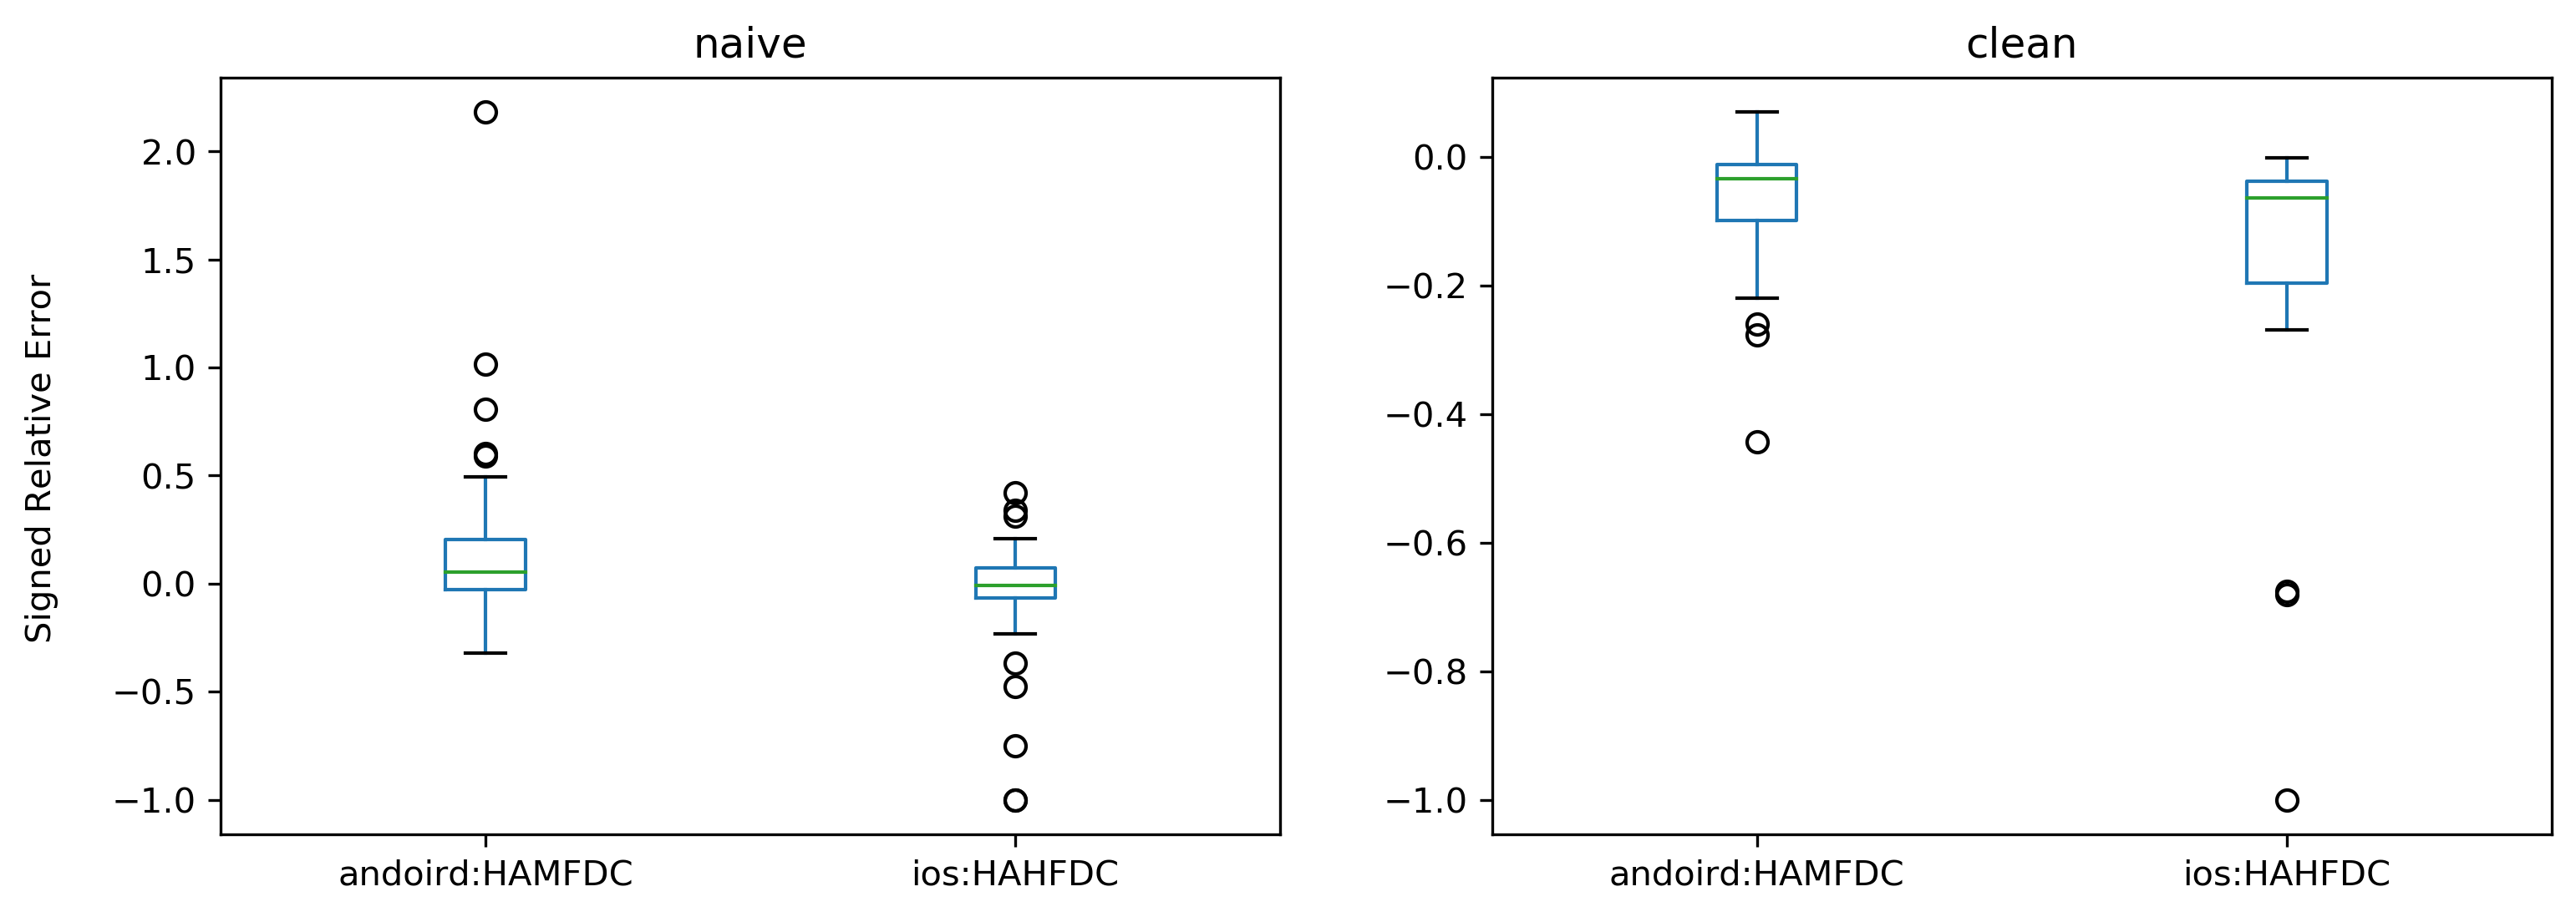

In [76]:
box_selected();

## Results

In [ ]:
2.811445**2

In [ ]:
get_describe_table('android', [pv_la, pv_sj, pv_ucb])

In [ ]:
0.291166**2

In [ ]:
get_describe_table('ios', [pv_la, pv_sj, pv_ucb])

### cleaned output

In [ ]:
0.156445**2

In [ ]:
get_describe_table('android', [av_la, av_sj, av_ucb])

In [ ]:
0.291166**2

In [ ]:
get_describe_table('ios', [av_la, av_sj, av_ucb])

In [ ]:
box_selected()

In [ ]:
import numpy as np 
import pylab 
import scipy.stats as stats
measurements = np.random.normal(loc = 20, scale = 5, size=100)
a_err, r_err_ios = get_approx_err('ios', 'HAMFDC', [pv_la, pv_la, pv_la]); np.array(r_err_ios)
r = np.array(r_err_ios).flatten()
print(measurements.shape, r.shape)
stats.probplot(r, dist="norm", plot=pylab)
pylab.show()

In [ ]:
measurements;
a_err, r_err_ios = get_approx_err('ios', 'HAMFDC', [av_la]); np.array(r_err_ios)


# investigate outlier

# JSON table 

In [ ]:
json_dump = json.dumps( 
    {
        "relative_distance_errors" :
        {
            "android:HAMF" : np.array(get_approx_err('android', 'HAMFDC')[-1]).tolist(),
            "ios:HAHF"     : np.array(get_approx_err('ios', 'HAHFDC')[-1]).tolist()
        }
    }
)
# Writing to relative_distance_errors.json
with open("tables/relative_distance_errors.json", "w") as outfile:
    outfile.write(json_dump)

# Function that takes in a spec detail (or spec details) and outputs a JSON table

In [ ]:
def get_relative_distance_error_table(sd, output_file_name="relative_distance_errors.json") :
    if type(sd) is not list: sd = [sd]
    pv_l = []
    av_l = []
    for s in sd:
        pv = eipv.PhoneView(sd)
        av = eapv.create_analysed_view(pv, s.DATASTORE_LOC, "analysis/recreated_location", "analysis/cleaned_trip", "analysis/cleaned_section")
        pv_l.append(pv_l)
        av_l.append(av_l)
    abs_err, rel_err = get_approx_err(os, role, pv_l=pv_l)
    json_dump = json.dumps( 
        {
            "relative_distance_errors" :
            {
                "android:HAMF" : np.array(get_approx_err('android', 'HAMFDC')[-1]).tolist(),
                "ios:HAHF"     : np.array(get_approx_err('ios', 'HAHFDC')[-1]).tolist()
            }
        }
    )
    # Writing to relative_distance_errors.json
    with open(output_file_name, "w") as outfile:
        outfile.write(json_dump)